# Estimativa Salarial Usando Modelos de Regressão

## Imports

In [602]:
# Bibliotecas padrão
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from pathlib import Path

# Scikit-learn: Pré-processamento
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    FunctionTransformer, 
    LabelEncoder, 
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler
)

# Scikit-learn: Divisão de dados
from sklearn.model_selection import (
    GridSearchCV, 
    KFold, 
    RandomizedSearchCV,
    cross_val_score,
    learning_curve, 
    train_test_split
)

# Scikit-learn: Modelos
from sklearn.ensemble import (
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor
)
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Modelos externos
from xgboost import XGBRegressor

# Scikit-learn: Métricas
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score
)

# Scikit-learn: Seleção de features
from sklearn.feature_selection import (
    RFECV,
    SelectFromModel,
    SelectKBest,
    SequentialFeatureSelector,
    f_regression,
)

# Scikit-learn: Pipeline
from sklearn.pipeline import Pipeline

# Scikit-learn: Inspeção de modelos
from sklearn.inspection import PartialDependenceDisplay

# Scikit-learn: Extração e redução de texto
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

## Dataset

In [603]:
data_path = Path("data_cleaned_2021.csv")
assert data_path.exists(), f"Arquivo não encontrado: {data_path}"

df = pd.read_csv(data_path)
assert not df.empty, "DataFrame está vazio"

df.replace({-1: np.nan}, inplace=True)

## Pré-processamento e limpeza

In [604]:
# Cria faixas para Rating
rating_bins = [0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
rating_labels = ['0 - 2.5', '2.6 - 3.0', '3.1 - 3.5', '3.6 - 4.0', '4.1 - 4.5', '4.6 - 5.0']
df['Rating_range'] = pd.cut(df['Rating'], bins=rating_bins, labels=rating_labels, include_lowest=True)

# Cria faixas para Age
age_bins = [0, 10, 20, 40, 60, 100, np.inf]
age_labels = ['0-10', '11-20', '21-40', '41-60', '61-100', '100+']
df['Age_range'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, include_lowest=True)

In [605]:
# Colunas numéricas, binárias, ordinais e categóricas
num_cols = [
    'Rating',
    'Age'
]

bin_cols = [
    'Python',
    'excel',
    'aws',
    'spark',
    'tableau',
    'hadoop',
    'tensor'
]

ord_cols = [
    'Size',                 # faixas de funcionários (1-50, 51-200, ...)
    # 'Rating_range',         # faixas de avaliação (0-2.5, 2.6-3.0, ...)
    # 'Age_range',            # faixas de idade (0-10, 11-20, ...)   
    'seniority_by_title',
    'Degree'        
]

cat_cols = [
    'company_txt',
    'Job Location',
    'Type of ownership',
    'Industry',
    'Sector',
    'Revenue',
    'job_title_sim'
]

# Colunas a remover (irrelevantes ou derivadas do target)
drop_cols = [
    # 'Rating',
    # 'Age',
    'sql',
    'sas',
    'keras',
    'pytorch',
    'scikit',
    'bi',
    'flink',
    'mongo',
    'google_an',
    'Founded',           # Ano de fundação não é uma feature relevante
    'Employer provided', # Coluna redundante, pois Hourly já indica se é por hora
    'Hourly',            # Coluna redundante, pois Employer provided já indica se é por hora
    'index',            # Índice não é uma feature relevante
    'Salary Estimate',  
    'Lower Salary',     
    'Upper Salary',     
    'Avg Salary(K)',    
    'Job Title',
    'Job Description',  
    'Location',
    'Headquarters',
    'Company Name',     # Faz o mesmo que company_txt
    'Competitors'
]

# Identificar colunas não citadas em nenhum dos grupos
all_used_cols = set(num_cols + bin_cols + ord_cols + cat_cols + drop_cols)
existing_cols = set(df.columns)
unused_cols = existing_cols - all_used_cols

if unused_cols:
    print("Colunas não citadas em nenhum grupo:", list(unused_cols))

missing_cols = [col for col in drop_cols if col not in df.columns]
if missing_cols:
    print("Colunas não encontradas no DataFrame e não serão removidas:", missing_cols)
features = df.drop(columns=[col for col in drop_cols if col in df.columns])
target = df['Avg Salary(K)']


num_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

bin_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

ord_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipe, num_cols),
    ('bin', bin_pipe, bin_cols),
    ('ord', ord_pipe, ord_cols),
    ('cat', cat_pipe, cat_cols)
])

Colunas não citadas em nenhum grupo: ['Age_range', 'Rating_range']


## Seleção de features

In [606]:
from sklearn.linear_model import LassoCV

sfm = SelectFromModel(
    LassoCV(cv=5, random_state=42),
    threshold='mean' 
)

est_base = Ridge(random_state=42)
rfecv = RFECV(
    estimator=est_base,
    step=5, 
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

to_dense = FunctionTransformer(
    func=lambda X: X.toarray() if hasattr(X, "toarray") else X,
    validate=False
)

# Pipeline sequencial: KBest ➔ RFECV
pipeline_seq = Pipeline([
    ('preprocessor', preprocessor),
    # ('sfm', sfm),
    ('rfecv', rfecv),
    ('to_dense', to_dense)
])

## Análise inicial


In [607]:
df.shape

(742, 44)

In [608]:
#show all columns
pd.set_option('display.max_columns', None)
#show all rows
df.head(3)

index                  Job Title              Salary Estimate  \
0      0             Data Scientist   $53K-$91K (Glassdoor est.)   
1      1  Healthcare Data Scientist  $63K-$112K (Glassdoor est.)   
2      2             Data Scientist   $80K-$90K (Glassdoor est.)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

In [609]:
df.describe()

,index,Rating,Founded,Hourly,Employer provided,Lower Salary,Upper Salary,Avg Salary(K),Age,Python,spark,aws,excel,sql,sas,keras,pytorch,scikit,tensor,hadoop,tableau,bi,flink,mongo,google_an
count,742.000000,731.000000,692.000000,742.000000,742.000000,742.000000,742.000000,742.000000,692.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000,742.000000
mean,469.129380,3.688372,1969.969653,0.032345,0.022911,74.754717,128.214286,101.484501,51.030347,0.528302,0.225067,0.237197,0.522911,0.512129,0.088949,0.039084,0.052561,0.072776,0.097035,0.167116,0.199461,0.075472,0.013477,0.049865,0.018868
std,279.793117,0.570353,54.089762,0.177034,0.149721,30.945892,45.128650,37.482449,54.089762,0.499535,0.417908,0.425651,0.499812,0.500190,0.284862,0.193925,0.223305,0.259944,0.296205,0.373331,0.399865,0.264329,0.115384,0.217813,0.136150
min,0.000000,1.900000,1744.000000,0.000000,0.000000,15.000000,16.000000,15.500000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,221.500000,3.300000,1958.000000,0.000000,0.000000,52.000000,96.000000,73.500000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,472.500000,3.700000,1992.000000,0.000000,0.000000,69.500000,124.000000,97.500000,29.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,707.750000,4.000000,2007.000000,0.000000,0.000000,91.000000,155.000000,122.500000,63.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,955.000000,5.000000,2019.000000,1.000000,1.000000,202.000000,306.000000,254.000000,277.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [610]:
df.isnull().sum() * 100 / df.shape[0]

index                 0.000000
Job Title             0.000000
Salary Estimate       0.000000
Job Description       0.000000
Rating                1.482480
Company Name          0.000000
Location              0.000000
Headquarters          0.000000
Size                  0.000000
Founded               6.738544
Type of ownership     0.000000
Industry              0.000000
Sector                0.000000
Revenue               0.000000
Competitors           0.000000
Hourly                0.000000
Employer provided     0.000000
Lower Salary          0.000000
Upper Salary          0.000000
Avg Salary(K)         0.000000
company_txt           0.000000
Job Location          0.000000
Age                   6.738544
Python                0.000000
spark                 0.000000
aws                   0.000000
excel                 0.000000
sql                   0.000000
sas                   0.000000
keras                 0.000000
pytorch               0.000000
scikit                0.000000
tensor  

<Axes: >

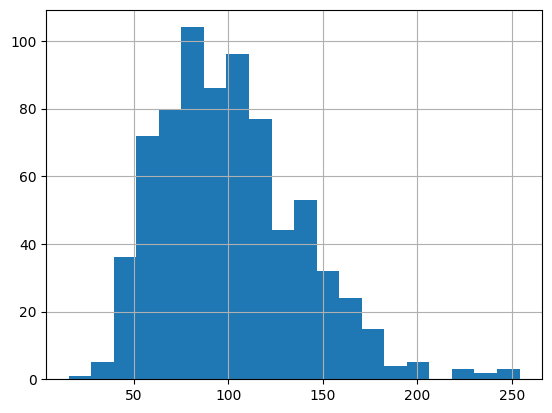

In [611]:
df['Avg Salary(K)'].hist(bins=20)

C:\Users\duike\AppData\Local\Temp\ipykernel_14076\2247197968.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



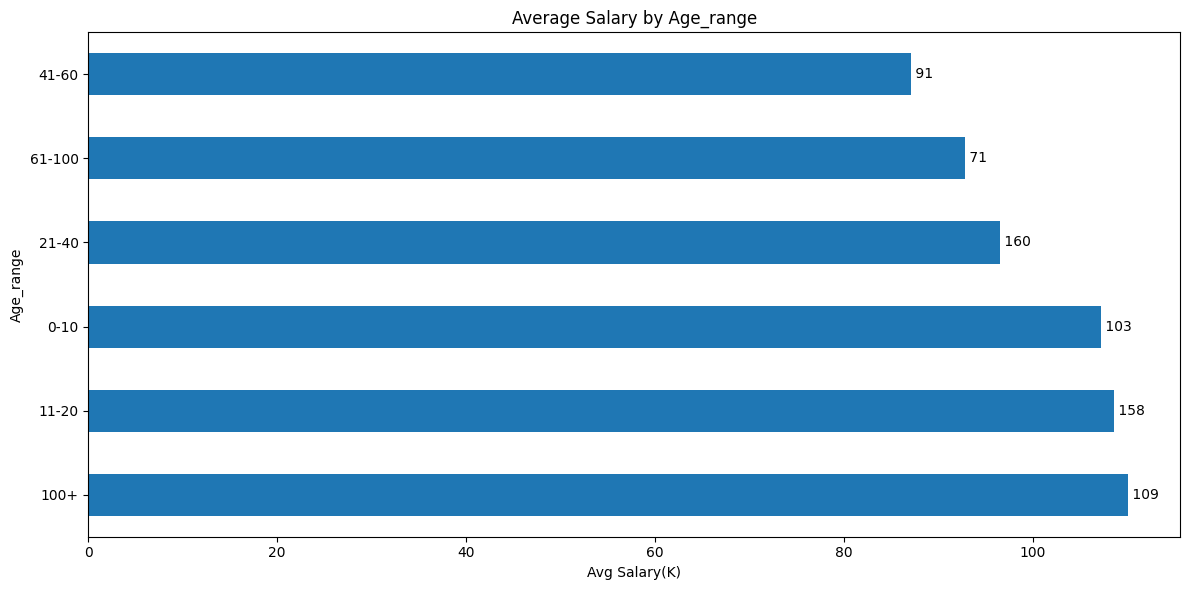

C:\Users\duike\AppData\Local\Temp\ipykernel_14076\2247197968.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



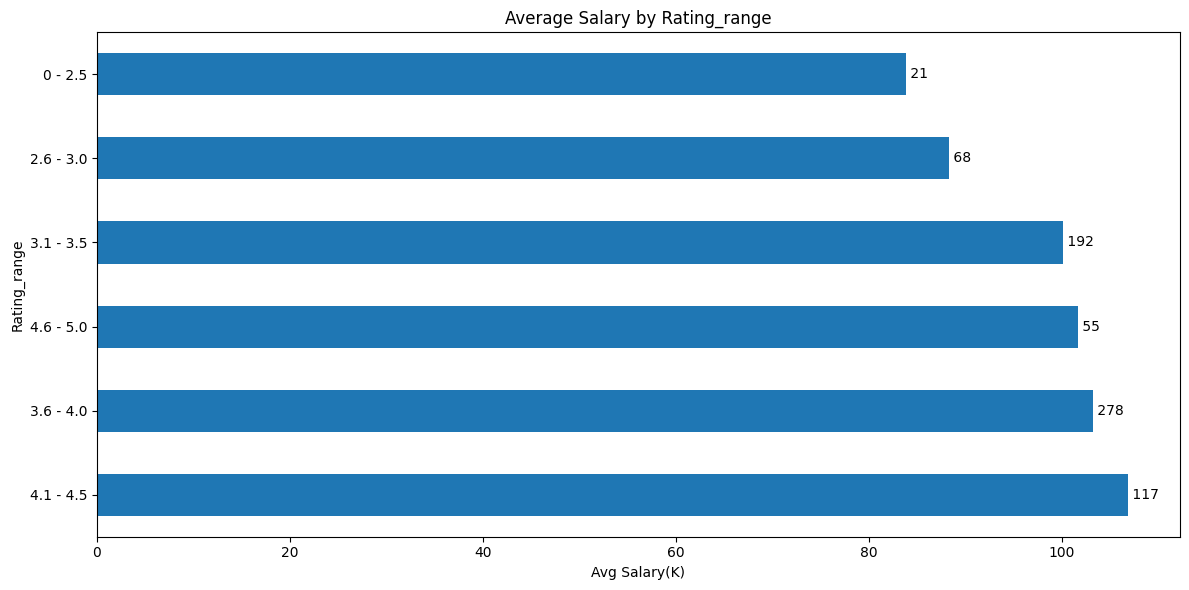

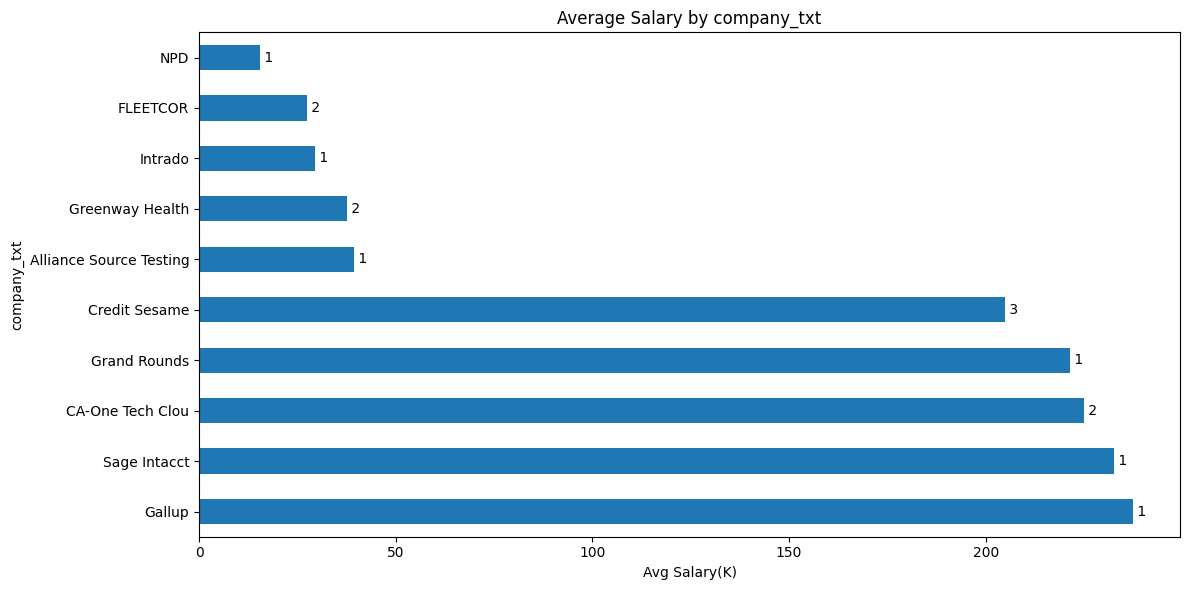

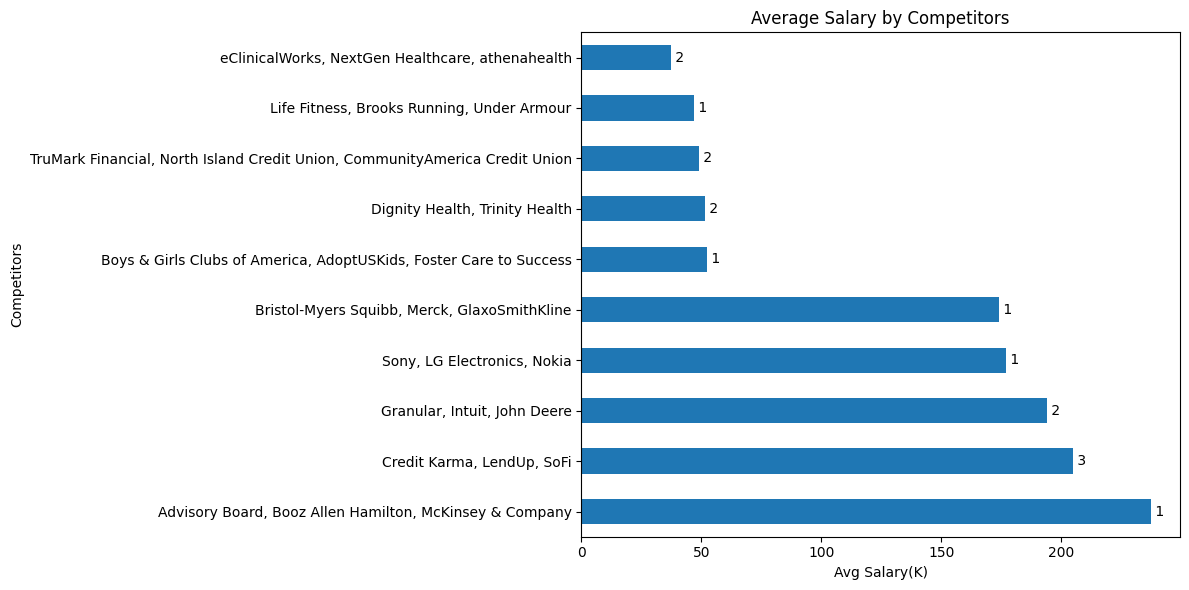

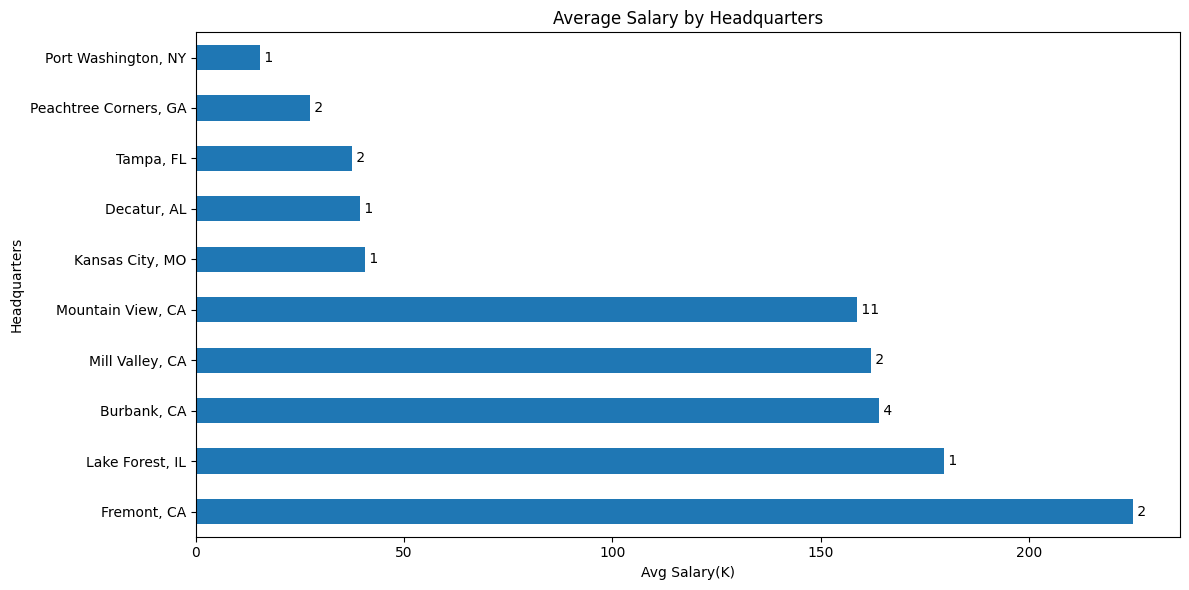

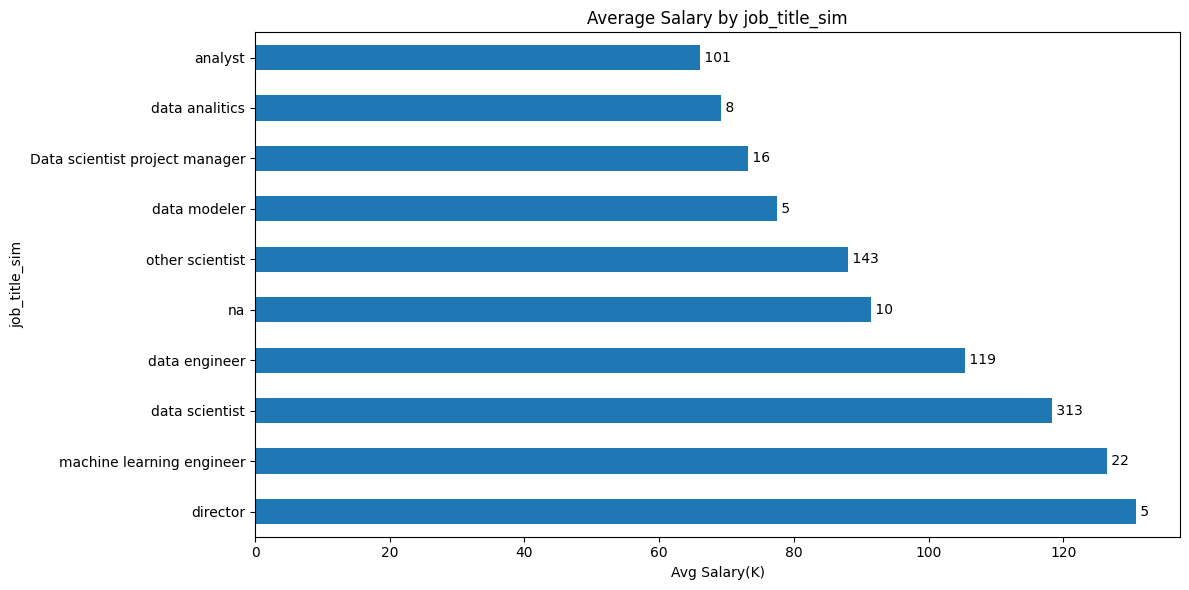

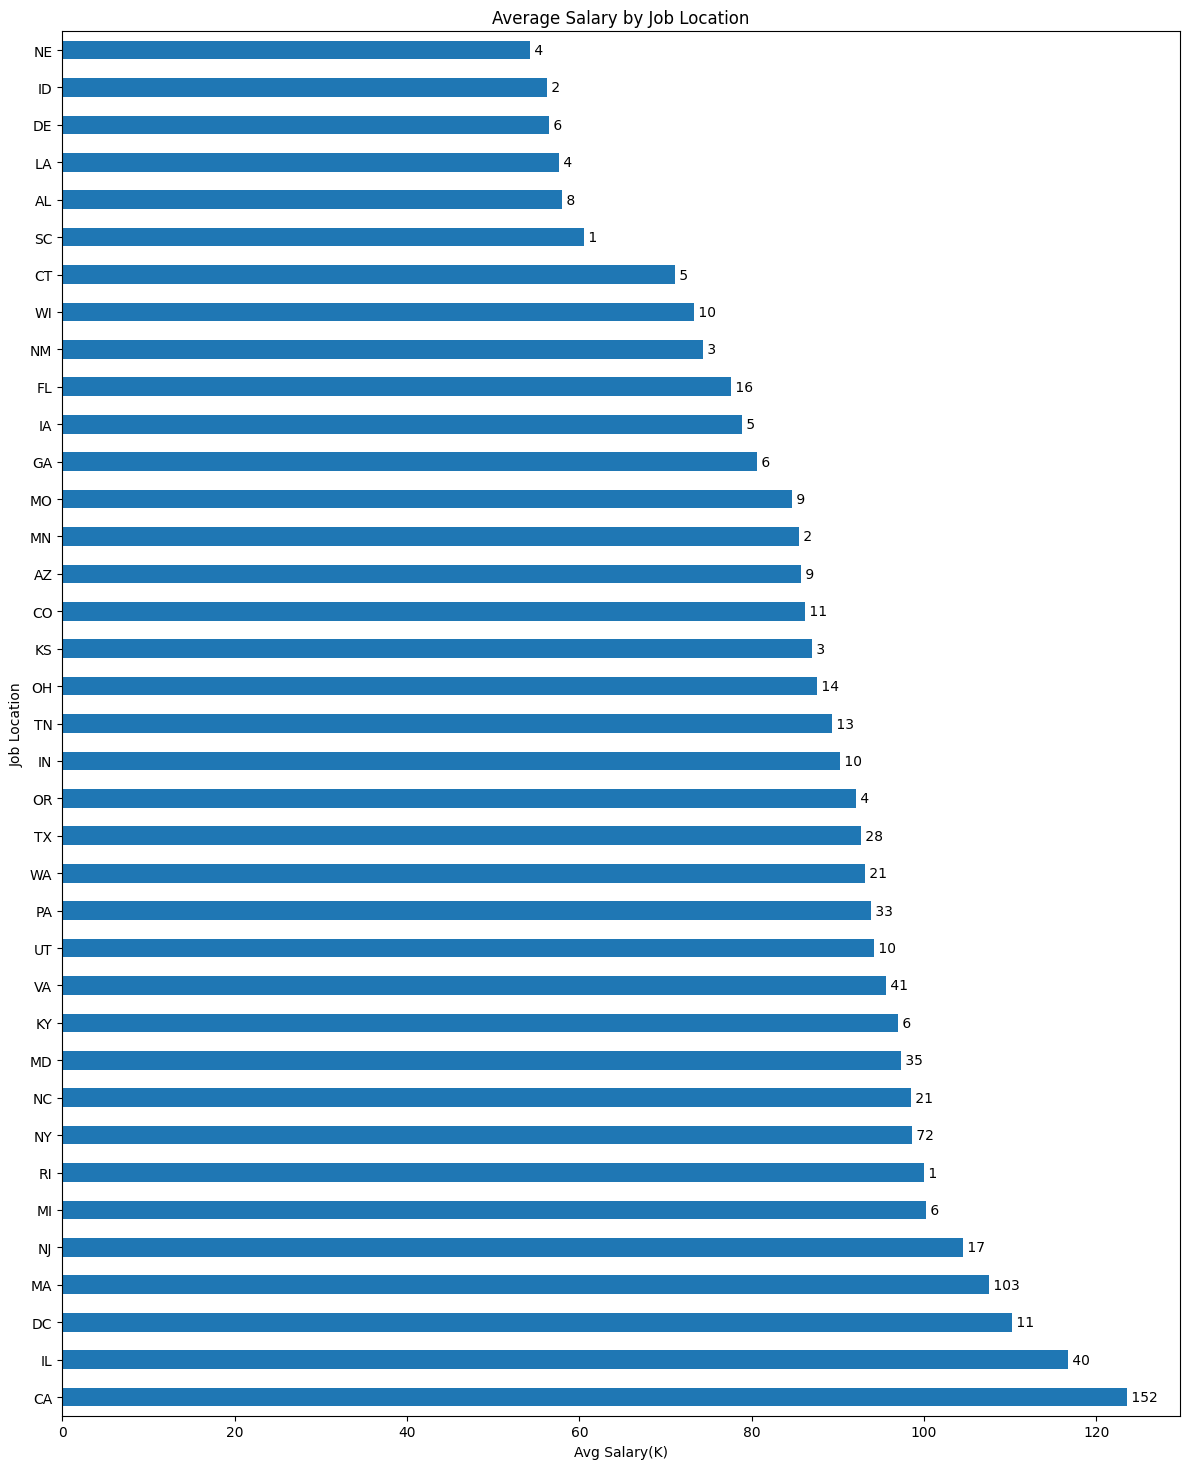

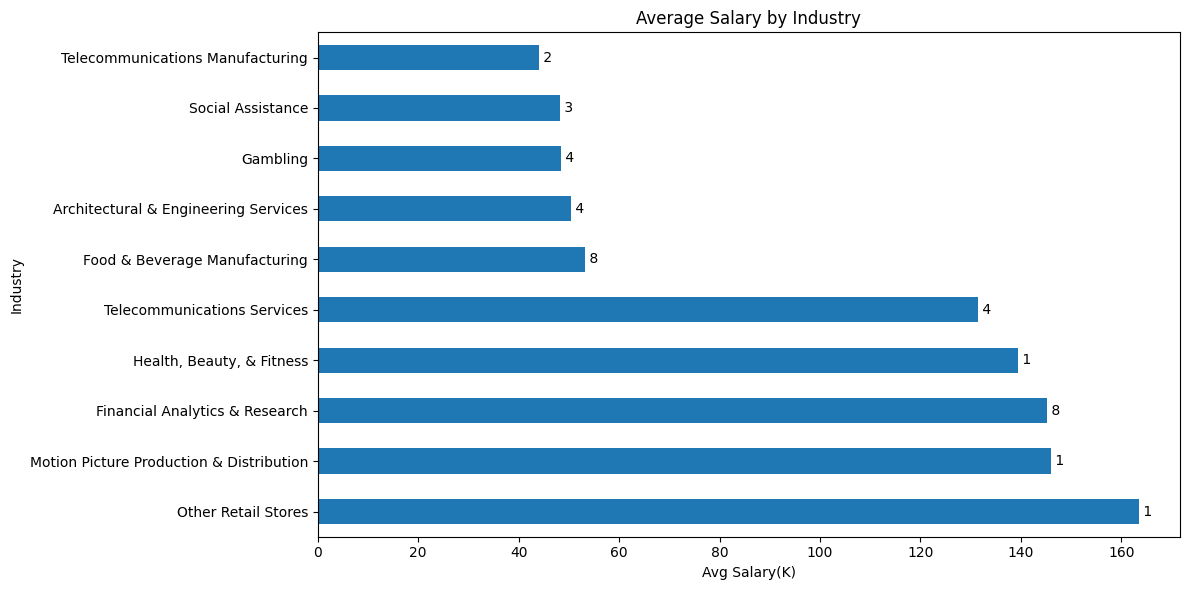

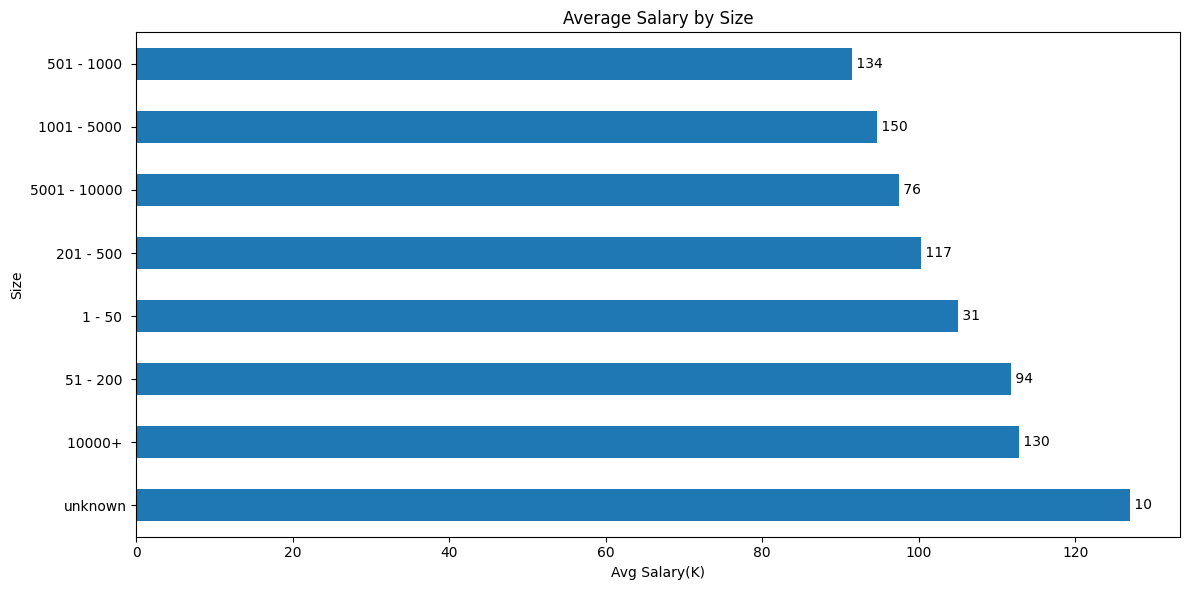

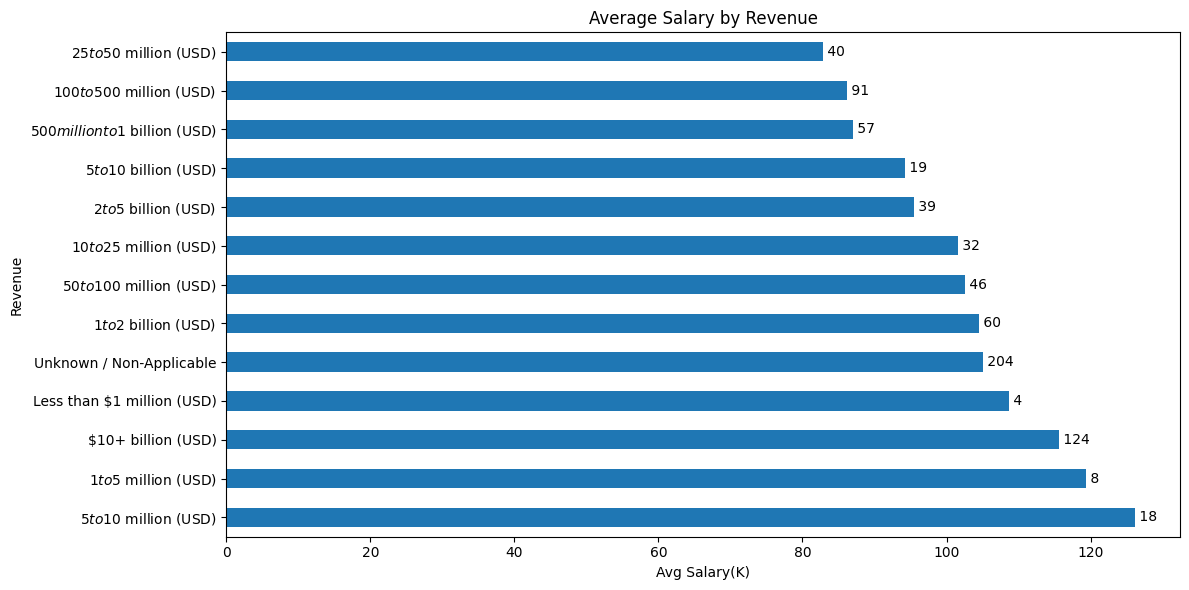

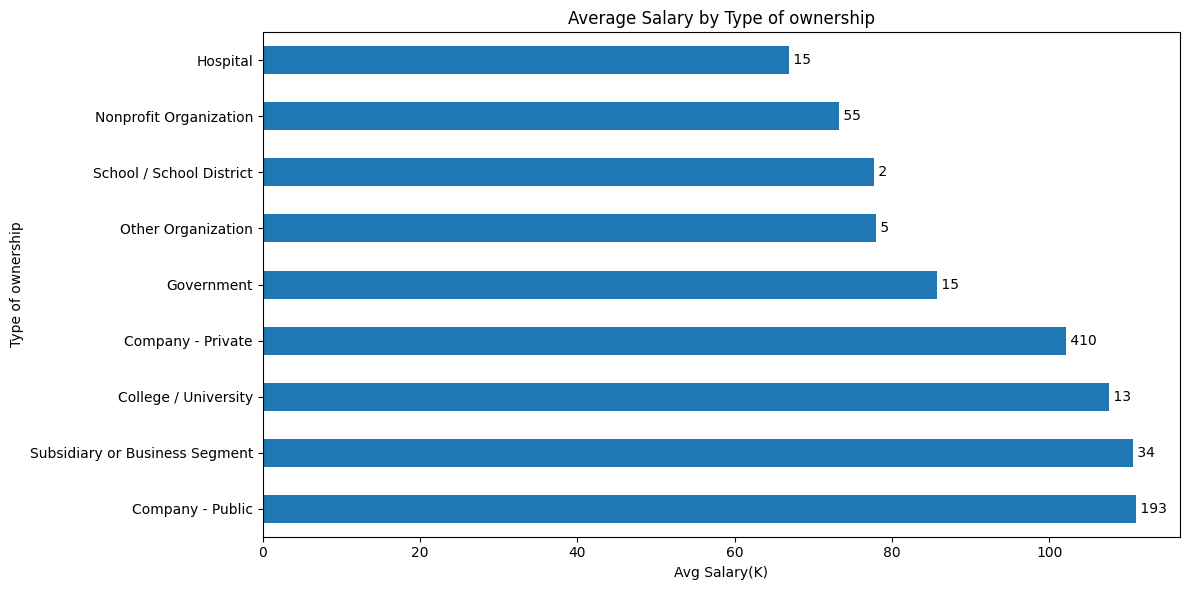

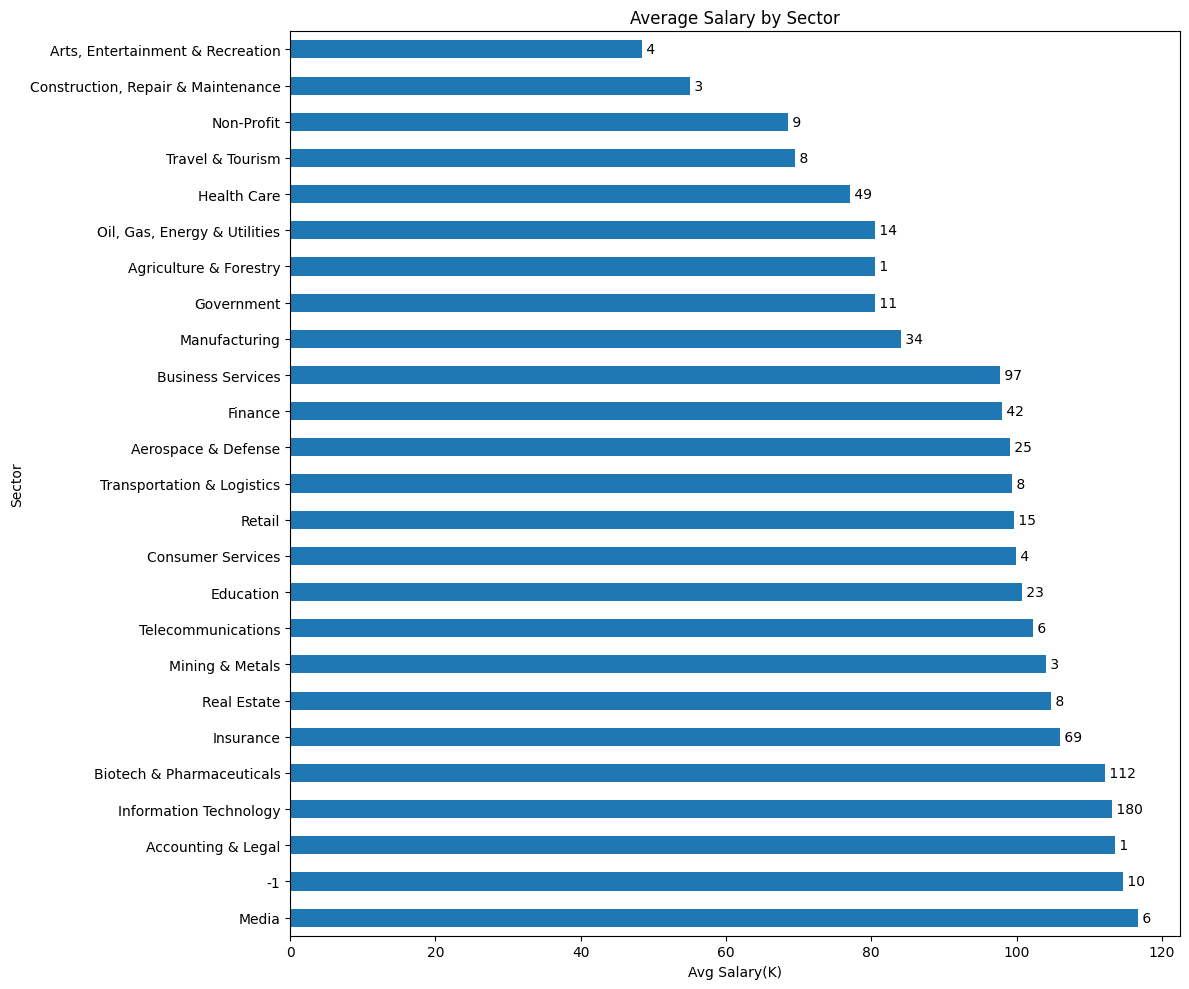

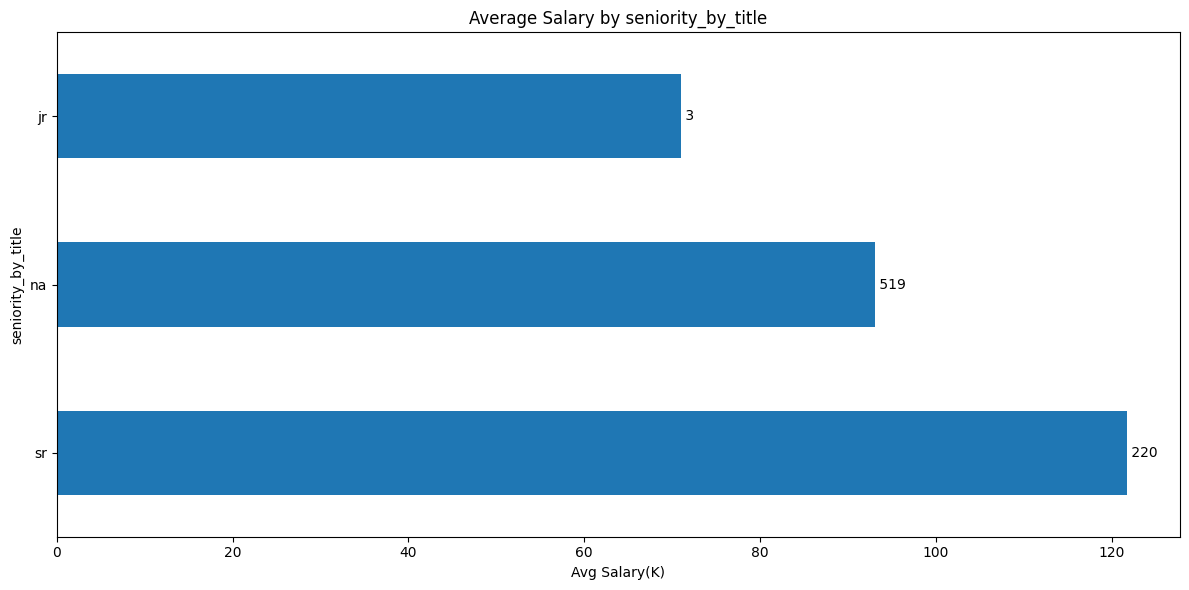

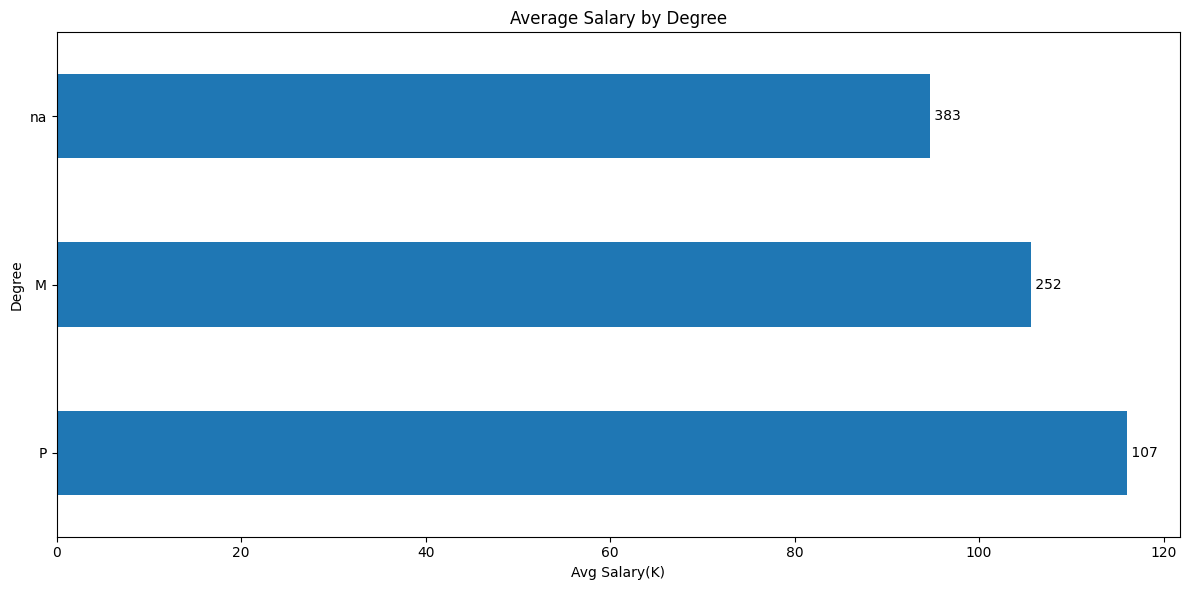

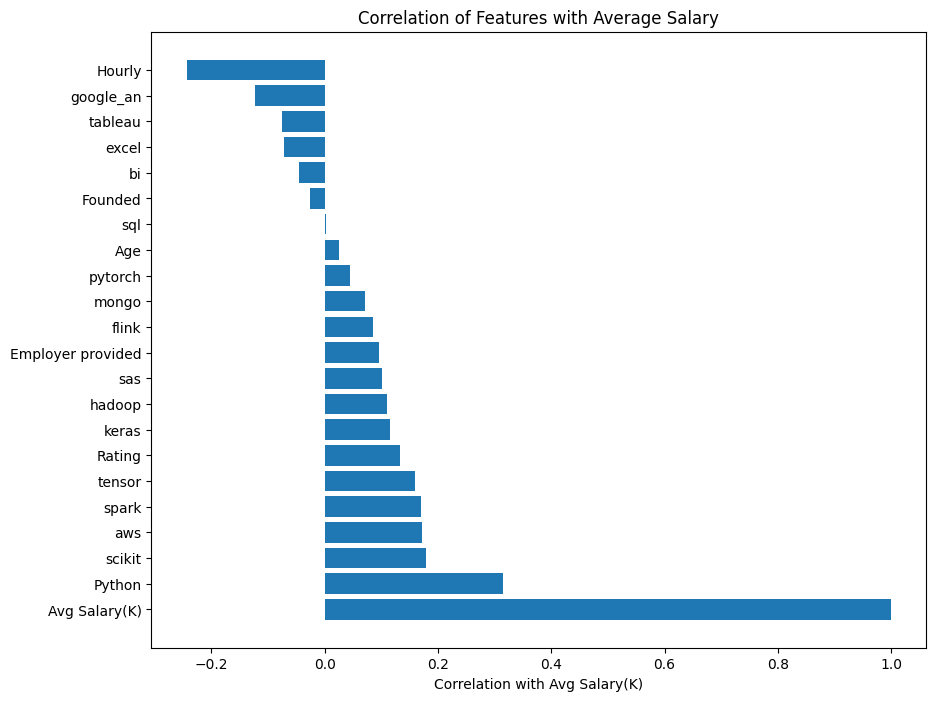

In [612]:
def plot_avg_salary_by_category(df, category_col):
    avg_salary = df.groupby(category_col)['Avg Salary(K)'].mean().sort_values(ascending=False)
    counts = df[category_col].value_counts()
    n = len(avg_salary)
    
    if n > 50:
        avg_salary = pd.concat([avg_salary.head(5), avg_salary.tail(5)])
    # Ajusta a altura da figura dinamicamente: 0.4 por categoria, mínimo 6, máximo 20
    height = min(max(len(avg_salary) * 0.4, 6), 20)
    plt.figure(figsize=(12, height))
    bars = avg_salary.plot(kind='barh')
    # Adiciona o total de observações como texto nas barras
    for i, (cat, val) in enumerate(avg_salary.items()):
        total = counts.get(cat, 0)
        plt.text(val, i, f' {total}', va='center', fontsize=10, color='black')
    plt.title(f'Average Salary by {category_col}')
    plt.xlabel('Avg Salary(K)')
    plt.tight_layout()
    plt.show()

category_columns = ['Age_range', 'Rating_range','company_txt', 'Competitors', 'Headquarters', 'job_title_sim', 'Job Location', 'Industry',  'Size', 'Revenue', 'Type of ownership', 'Sector', 'seniority_by_title', 'Degree']

for category in category_columns:
    plot_avg_salary_by_category(df, category)


skill_columns = ['Python', 'spark', 'aws', 'excel', 'sql', 'sas', 'keras', 'pytorch',
                 'scikit', 'tensor', 'hadoop', 'tableau', 'bi', 'flink', 'mongo', 'google_an']

# Ter certeza de que as colunas de habilidades são do tipo int
df[skill_columns] = df[skill_columns].fillna(0).astype(int)

# Adicionar essas colunas numéricas à análise
df_corr = df[['Avg Salary(K)', 'Rating', 'Founded', 'Age', 'Employer provided', 'Hourly'] + skill_columns]

# Calcular correlação e ordenar
correlation = df_corr.corr()
corr_with_salary = correlation['Avg Salary(K)'].sort_values(ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(corr_with_salary.index, corr_with_salary.values)
plt.xlabel('Correlation with Avg Salary(K)')
plt.title('Correlation of Features with Average Salary')
plt.show()


In [613]:
import plotly.express as px

state_salary = df.groupby('Job Location')['Avg Salary(K)'].mean().reset_index()

fig = px.choropleth(
    state_salary,
    locations='Job Location',
    locationmode="USA-states",
    color='Avg Salary(K)',
    color_continuous_scale="bluered",
    scope="usa",
    labels={'Avg Salary(K)': 'Avg Salary (K)'},
    title='Salário médio por estado dos EUA',
)
fig.update_layout(width=1000, height=700)
fig.show()

In [614]:
import pandas as pd

# Análise de impacto de skills no salário
skill_impact = {}
for skill in skill_columns:
    has_skill = df[df[skill] == 1]['Avg Salary(K)'].mean()
    no_skill = df[df[skill] == 0]['Avg Salary(K)'].mean()
    skill_impact[skill] = {
        'with_skill': has_skill,
        'without_skill': no_skill,
        'difference': has_skill - no_skill,
        'percentage_increase': ((has_skill - no_skill) / no_skill) * 100
    }

# Ordenar por impacto
sorted_skills = sorted(skill_impact.items(), 
                      key=lambda x: x[1]['difference'], reverse=True)

# Exibir resultados

# Exibir todos os resultados completos em formato de DataFrame
df_skill_impact = pd.DataFrame([
    {
        'Skill': skill,
        'Com habilidade (K)': impact['with_skill'],
        'Sem habilidade (K)': impact['without_skill'],
        'Aumento (%)': impact['percentage_increase'],
        'Qtd com habilidade': df[df[skill] == 1].shape[0],
        'Confiabilidade dos dados': 'Maior' if df[df[skill] == 1].shape[0] > 100 else 'Menor'
    }
    for skill, impact in sorted_skills
])

# Ordena primeiro por confiabilidade (Alta antes), depois por diferença (K) decrescente
df_skill_impact['Confiabilidade dos dados'] = pd.Categorical(
    df_skill_impact['Confiabilidade dos dados'], categories=['Maior', 'Menor'], ordered=True
)

df_skill_impact = df_skill_impact.sort_values(
    by=['Confiabilidade dos dados', 'Aumento (%)'], ascending=[True, False]
).reset_index(drop=True)

# Configura o pandas para mostrar todas as linhas e colunas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

display(df_skill_impact)

,Skill,Com habilidade (K),Sem habilidade (K),Aumento (%),Qtd com habilidade,Confiabilidade dos dados
0,Python,112.653061,88.975714,26.611022,392,Maior
1,spark,113.347305,98.039130,15.614352,167,Maior
2,aws,113.082386,97.878092,15.533910,176,Maior
3,hadoop,110.729839,99.629450,11.141674,124,Maior
4,sql,101.557895,101.407459,0.148348,380,Maior
5,excel,98.896907,104.320621,-5.199082,388,Maior
6,tableau,95.875000,102.882155,-6.810855,148,Maior
7,flink,129.000000,101.108607,27.585578,10,Menor
8,scikit,125.314815,99.614099,25.800280,54,Menor
9,keras,122.965517,100.610799,22.219004,29,Menor


## Treinamento e teste

### Funções de treinamento

#### GridSearchCV

In [615]:
def train_and_evaluate(pipeline, estimator, param_grid, 
                    X_train, y_train, X_test, y_test):

    """
    Combina pipeline (pré-processamento + seleção) com modelo,
    executa GridSearchCV e retorna grid e métricas de teste.
    """

    full_pipe = Pipeline([('pipe', pipeline),
                          ('model', estimator)])
    
    # Constrói o param_grid para GridSearchCV
    gs_params = {}
    for key, values in param_grid.items():
        if '__' in key:
            # parãmetro de pipeline (como 'kbest__k')
            gs_params[f'pipe__{key}'] = values
        else:
            # parâmetro do estimador (como 'alpha')
            gs_params[f'model__{key}'] = values

    grid = GridSearchCV(
        full_pipe,
        param_grid=gs_params,
        cv=5 ,
        scoring='r2',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)
    
    # Previsão com melhor modelo encontrado
    best_estimator = grid.best_estimator_
    y_pred = best_estimator.predict(X_test)
    
    # Cálculo de métricas
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    
    return {        
        'best_estimator': best_estimator,
        'best_params': grid.best_params_,
        'best_score': grid.best_score_,
        'cv_results': grid.cv_results_,
        'y_pred': y_pred,
        'mae': mae,
        'rmse': rmse,        
        'r2': r2
    }

#### NestedCV

In [616]:
def nested_cv_evaluate(pipeline, estimator, param_grid,
                       X, y, outer_folds=5, inner_folds=3,
                       scoring='r2'):
    
    full_pipe = Pipeline([('pipe', pipeline), 
                          ('model', estimator)])

    # prefixa parâmetros
    gs_params = {}
    for key, vals in param_grid.items():
        if '__' in key:
            gs_params[f'pipe__{key}'] = vals
        else:
            gs_params[f'model__{key}'] = vals

    # GridSearch interno
    inner_cv = KFold(n_splits=inner_folds, shuffle=True, random_state=42)
    grid = GridSearchCV(
        full_pipe,
        param_grid=gs_params,
        cv=inner_cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=0
    )
    # Avaliação externa
    outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=1)
    scores = cross_val_score(
        grid, 
        X, y,
        cv=outer_cv,
        scoring=scoring,
        n_jobs=-1,
        verbose=0
    )
    return scores

In [617]:
# --- Nested CV detalhado ---
def nested_cv_detailed(pipeline, estimator, param_grid,
                       X, y, outer_folds=5, inner_folds=3,
                       scoring='r2'):
    
    outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=1)
    results = []
    for train_idx, test_idx in outer_cv.split(X):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
        # Inner GridSearch
        grid = GridSearchCV(
            Pipeline([('pipe', pipeline), ('model', estimator)]),
            param_grid={f"model__{k}":v for k,v in param_grid.items()},
            cv=KFold(n_splits=inner_folds, shuffle=True, random_state=42),
            scoring=scoring, n_jobs=-1, verbose=0
        )
        grid.fit(X_tr, y_tr)
        best = grid.best_estimator_
        y_pred = best.predict(X_te)
        r2_ext = r2_score(y_te, y_pred)
        mae_ext = mean_absolute_error(y_te, y_pred)
        rmse_ext = np.sqrt(mean_squared_error(y_te, y_pred))
        results.append({
            'best_params': grid.best_params_,
            'best_inner_score': grid.best_score_,
            'r2': r2_ext,
            'mae': mae_ext,
            'rmse': rmse_ext
        })
    # Cálculo de médias e desvios
    summary = {
        'r2_mean': np.mean([r['r2'] for r in results]),
        'r2_std':  np.std([r['r2'] for r in results]),
        'mae_mean': np.mean([r['mae'] for r in results]),
        'mae_std':  np.std([r['mae'] for r in results]),
        'rmse_mean': np.mean([r['rmse'] for r in results]),
        'rmse_std':  np.std([r['rmse'] for r in results]),
    }
    return results, summary


### Divisão do dataset em treino e teste

In [618]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

### Execução dos modelos

#### Lasso

In [619]:
# Regressão Linear com regularização L1
estimator_lasso = Lasso(random_state=42)

param_grid_ridge = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]
}

result_lasso = train_and_evaluate(
    pipeline_seq,
    estimator_lasso,
    param_grid_ridge,
    X_train, 
    y_train,
    X_test,   
    y_test
)
print(            
        f"| MAE: {result_lasso['mae']:.2f} "
        f"| RMSE: {result_lasso['rmse']:.2f} "
        f"| R²: {result_lasso['r2']:.4f} |"
    )

Fitting 5 folds for each of 5 candidates, totalling 25 fits


| MAE: 14.16 | RMSE: 21.72 | R²: 0.6993 |


In [620]:
# 2) Avaliação robusta via Nested CV detalhado
results_lasso_nested, summary_lasso_nested = nested_cv_detailed(
    pipeline_seq,
    estimator_lasso,
    param_grid_ridge,
    features, 
    target,
    outer_folds=3,
    inner_folds=5
)
print(
    f"Nested CV R² médio: {summary_lasso_nested['r2_mean']:.4f} ± {summary_lasso_nested['r2_std']:.4f}"
)

print("Resultados por Fold (Ridge Nested CV):")
print("-" * 50)
for i, res in enumerate(results_lasso_nested, start=0):
    params = res['best_params']
    inner = res['best_inner_score']
    outer = res['r2']
    mae   = res['mae']
    rmse  = res['rmse']
    print(f"Fold {i}:")
    print(f"  Best Params:       {params}")
    print(f"  Inner CV R²:       {inner:.4f}")
    print(f"  Outer Hold‑out R²: {outer:.4f}")
    print(f"  Outer MAE:         {mae:.2f}")
    print(f"  Outer RMSE:        {rmse:.2f}")
    print("-" * 50)

c:\Users\duike\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


2 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\duike\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py", line 72, in __call__
    return self.func(**kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\duike\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Use

Nested CV R² médio: 0.3690 ± 0.0791
Resultados por Fold (Ridge Nested CV):
--------------------------------------------------
Fold 0:
  Best Params:       {'model__alpha': 0.1}
  Inner CV R²:       0.1114
  Outer Hold‑out R²: 0.4799
  Outer MAE:         19.74
  Outer RMSE:        26.85
--------------------------------------------------
Fold 1:
  Best Params:       {'model__alpha': 0.0001}
  Inner CV R²:       0.2224
  Outer Hold‑out R²: 0.3257
  Outer MAE:         18.99
  Outer RMSE:        31.13
--------------------------------------------------
Fold 2:
  Best Params:       {'model__alpha': 0.0001}
  Inner CV R²:       0.0857
  Outer Hold‑out R²: 0.3014
  Outer MAE:         17.94
  Outer RMSE:        31.03
--------------------------------------------------


c:\Users\duike\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.765e+03, tolerance: 7.005e+01



#### RandomForest

In [635]:
estimator_rf = RandomForestRegressor(random_state=42)

param_grid_rf = {
    'n_estimators': [50, 100, 200, 400],         # Número de árvores na floresta
    'max_depth': [3, 5, 10, None],           # Profundidade máxima das árvores
    'min_samples_split': [2, 5],        # Número mínimo de amostras necessárias para dividir um nó      
    'max_features': ['sqrt', 'log2', None], # Número de recursos a serem considerados ao procurar a melhor divisão
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1]         # Parâmetro de complexidade para poda   
}

result_rf = train_and_evaluate(
    pipeline_seq,
    estimator_rf,
    param_grid_rf,
    X_train, 
    y_train,
    X_test,  
    y_test
)

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


c:\Users\duike\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


16 fits failed out of a total of 1920.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\duike\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py", line 72, in __call__
    return self.func(**kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\duike\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "c:\

#### XGBoost

In [622]:
estimator_xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

param_grid_xgb = {
    'n_estimators': [700, 900],
    'learning_rate': [0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.6, 0.8],
    'alpha': [0, 1, 10],
    'lambda': [1, 10],
    'ccp_alpha': [0, 0.001, 0.01, 0.1]
}

result_xgb = train_and_evaluate(
    pipeline_seq,
    estimator_xgb,
    param_grid_xgb,
    X_train, 
    y_train,
    X_test,   
    y_test
)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


c:\Users\duike\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning:


16 fits failed out of a total of 2880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "c:\Users\duike\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\_utils.py", line 72, in __call__
    return self.func(**kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "c:\Users\duike\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\parallel.py", line 598, in __call__
    return [func(*args, **kwargs)
            ^^^^^^^^^^^^^^^^^^^^^
  File "c:\

In [623]:
# # 2) Avaliação robusta via Nested CV detalhado
# results_xgb_nested, summary_xgb_nested = nested_cv_detailed(
#     pipeline_seq,
#     estimator_xgb,
#     param_grid_xgb,
#     features, 
#     target,
#     outer_folds=3,
#     inner_folds=5
# )
# print(
#     f"Nested CV R² médio: {summary_xgb_nested['r2_mean']:.4f} ± {summary_xgb_nested['r2_std']:.4f}"
# )

# print("Resultados por Fold (Ridge Nested CV):")
# print("-" * 50)
# for i, res in enumerate(results_xgb_nested, start=0):
#     params = res['best_params']
#     inner = res['best_inner_score']
#     outer = res['r2']
#     mae   = res['mae']
#     rmse  = res['rmse']
#     print(f"Fold {i}:")
#     print(f"  Best Params:       {params}")
#     print(f"  Inner CV R²:       {inner:.4f}")
#     print(f"  Outer Hold‑out R²: {outer:.4f}")
#     print(f"  Outer MAE:         {mae:.2f}")
#     print(f"  Outer RMSE:        {rmse:.2f}")
#     print("-" * 50)

## Resultados

### Melhores combinações de hiperparâmetros

In [624]:
# Imprime melhores parâmetros, melhor score e top N combos de hiperparâmetros
def print_search_results(result, model_name, top_n=20):
    print(
        f"Modelo {model_name} \n\n"
        f"Melhores parâmetros: {result['best_params']} \n"
        f"Melhor score médio: {result['best_score']:.4f} \n\n"
        f"Top {top_n} combinações de hiperparâmetros:"
    )
    df = pd.DataFrame(result['cv_results'])
    display(df.sort_values(by='mean_test_score', ascending=False).head(top_n))

#### Ridge

In [625]:
print_search_results(result_lasso, "Ridge")

Modelo Ridge 

Melhores parâmetros: {'model__alpha': 0.01} 
Melhor score médio: 0.0053 

Top 20 combinações de hiperparâmetros:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,4.050532,1.066171,0.013404,0.001926,0.01,{'model__alpha': 0.01},-0.015372,0.064816,-0.018474,-0.003807,-0.000733,0.005286,0.030509,1
1,3.661087,0.245520,0.019443,0.010689,0.001,{'model__alpha': 0.001},-0.015438,0.064851,-0.018413,-0.003839,-0.000746,0.005283,0.030525,2
0,3.697532,0.167645,0.025371,0.011516,0.0001,{'model__alpha': 0.0001},-0.015444,0.064851,-0.018407,-0.003843,-0.000747,0.005282,0.030525,3
3,3.456689,0.392103,0.009446,0.005385,0.1,{'model__alpha': 0.1},-0.014727,0.061480,-0.019092,-0.003486,-0.000608,0.004714,0.029198,4
4,3.234238,0.020736,0.006420,0.001884,1.0,{'model__alpha': 1.0},-0.010997,-0.000077,-0.023100,-0.001809,-0.000384,-0.007274,0.008871,5


#### RandomForest

In [626]:
print_search_results(result_rf, "RandomForest")

Modelo RandomForest 

Melhores parâmetros: {'model__ccp_alpha': 0.0, 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 50} 
Melhor score médio: 0.0054 

Top 20 combinações de hiperparâmetros:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__ccp_alpha,param_model__max_depth,param_model__max_features,param_model__min_samples_split,param_model__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.430638,0.028968,0.018352,0.003453,0.0,3,sqrt,2,50,"{'model__ccp_alpha': 0.0, 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1
72,5.322394,0.550238,0.055590,0.018369,0.0,None,sqrt,2,50,"{'model__ccp_alpha': 0.0, 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1
148,4.336772,0.220322,0.042868,0.017529,0.001,10,sqrt,5,50,"{'model__ccp_alpha': 0.001, 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1
144,4.430226,0.107428,0.036875,0.011083,0.001,10,sqrt,2,50,"{'model__ccp_alpha': 0.001, 'model__max_depth': 10, 'model__max_features': 'sqrt', 'model__min_samples_split': 2, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1
292,4.519250,0.142299,0.037794,0.005603,0.1,3,sqrt,5,50,"{'model__ccp_alpha': 0.1, 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__min_samples_split': 5, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1
140,4.464045,0.263963,0.040219,0.011984,0.001,5,None,5,50,"{'model__ccp_alpha': 0.001, 'model__max_depth': 5, 'model__max_features': None, 'model__min_samples_split': 5, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1
296,4.344939,0.061868,0.036010,0.003986,0.1,3,log2,2,50,"{'model__ccp_alpha': 0.1, 'model__max_depth': 3, 'model__max_features': 'log2', 'model__min_samples_split': 2, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1
136,4.607721,0.068631,0.036645,0.002774,0.001,5,None,2,50,"{'model__ccp_alpha': 0.001, 'model__max_depth': 5, 'model__max_features': None, 'model__min_samples_split': 2, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1
300,4.633860,0.370526,0.045091,0.011384,0.1,3,log2,5,50,"{'model__ccp_alpha': 0.1, 'model__max_depth': 3, 'model__max_features': 'log2', 'model__min_samples_split': 5, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1
132,4.814126,0.281362,0.051147,0.010643,0.001,5,log2,5,50,"{'model__ccp_alpha': 0.001, 'model__max_depth': 5, 'model__max_features': 'log2', 'model__min_samples_split': 5, 'model__n_estimators': 50}",-0.013415,0.06441,-0.017775,-0.005549,-0.00066,0.005402,0.030099,1


#### XGBoost

In [627]:
print_search_results(result_xgb, "XGBoost")

Modelo XGBoost 

Melhores parâmetros: {'model__alpha': 10, 'model__ccp_alpha': 0.01, 'model__colsample_bytree': 0.6, 'model__lambda': 10, 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 900, 'model__subsample': 1.0} 
Melhor score médio: 0.2576 

Top 20 combinações de hiperparâmetros:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__alpha,param_model__ccp_alpha,param_model__colsample_bytree,param_model__lambda,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
495,4.092744,0.158316,0.012935,0.001169,10,0.01,0.6,10,0.2,3,900,1.0,"{'model__alpha': 10, 'model__ccp_alpha': 0.01, 'model__colsample_bytree': 0.6, 'model__lambda': 10, 'model__learning_rate': 0.2, 'model__max_depth': 3, 'model__n_estimators': 900, 'model__subsample': 1.0}",-0.015292,0.064699,0.617583,-0.003766,0.624811,0.257607,0.298136,1
484,5.461634,1.374761,0.030938,0.036391,10,0.01,0.6,1,0.2,5,700,0.8,"{'model__alpha': 10, 'model__ccp_alpha': 0.01, 'model__colsample_bytree': 0.6, 'model__lambda': 1, 'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 700, 'model__subsample': 0.8}",-0.012198,0.614508,-0.015481,-0.005111,0.691562,0.254656,0.326204,2
525,4.462637,1.490756,0.013407,0.001449,10,0.01,0.8,10,0.2,7,700,1.0,"{'model__alpha': 10, 'model__ccp_alpha': 0.01, 'model__colsample_bytree': 0.8, 'model__lambda': 10, 'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 700, 'model__subsample': 1.0}",-0.015292,0.064699,0.557603,-0.003766,0.658898,0.252428,0.293565,3
346,3.566868,0.113987,0.012156,0.001809,1,0.1,0.6,1,0.2,7,900,0.8,"{'model__alpha': 1, 'model__ccp_alpha': 0.1, 'model__colsample_bytree': 0.6, 'model__lambda': 1, 'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 900, 'model__subsample': 0.8}",-0.014134,0.064812,-0.020396,-0.003300,0.690949,0.143586,0.275373,4
532,3.926422,0.297641,0.012596,0.000968,10,0.1,0.6,1,0.2,5,700,0.8,"{'model__alpha': 10, 'model__ccp_alpha': 0.1, 'model__colsample_bytree': 0.6, 'model__lambda': 1, 'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 700, 'model__subsample': 0.8}",-0.012198,0.064778,-0.015481,-0.005111,0.675715,0.141541,0.268713,5
283,4.749396,2.289218,0.020535,0.015773,1,0.001,0.8,10,0.2,5,900,1.0,"{'model__alpha': 1, 'model__ccp_alpha': 0.001, 'model__colsample_bytree': 0.8, 'model__lambda': 10, 'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 900, 'model__subsample': 1.0}",-0.015430,0.064849,-0.018421,-0.003835,0.678758,0.141184,0.270498,6
236,4.767534,2.661734,0.040235,0.055951,1,0,0.8,10,0.2,7,700,0.8,"{'model__alpha': 1, 'model__ccp_alpha': 0, 'model__colsample_bytree': 0.8, 'model__lambda': 10, 'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 700, 'model__subsample': 0.8}",-0.012137,0.064781,-0.015513,-0.005097,0.672183,0.140843,0.267304,7
499,5.008034,1.277465,0.013498,0.002897,10,0.01,0.6,10,0.2,5,900,1.0,"{'model__alpha': 10, 'model__ccp_alpha': 0.01, 'model__colsample_bytree': 0.6, 'model__lambda': 10, 'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 900, 'model__subsample': 1.0}",-0.015292,0.064699,-0.018550,-0.003766,0.676953,0.140809,0.269781,8
441,4.188407,1.714863,0.018527,0.013295,10,0.001,0.6,1,0.2,7,700,1.0,"{'model__alpha': 10, 'model__ccp_alpha': 0.001, 'model__colsample_bytree': 0.6, 'model__lambda': 1, 'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 700, 'model__subsample': 1.0}",-0.015292,0.064699,-0.018550,-0.003766,0.676823,0.140783,0.269729,9
260,3.453840,0.058237,0.012546,0.001241,1,0.001,0.6,10,0.2,7,700,0.8,"{'model__alpha': 1, 'model__ccp_alpha': 0.001, 'model__colsample_bytree': 0.6, 'model__lambda': 10, 'model__learning_rate': 0.2, 'model__max_depth': 7, 'model__n_estimators': 700, 'model__subsample': 0.8}",-0.012137,0.064781,-0.015513,-0.005097,0.670481,0.140503,0.266627,10


### Medidas de desempenho

In [637]:
def print_metrics(result, model_name):         
        print(
            f"{model_name} → "            
            f"| MAE: {result['mae']:.2f} "
            f"| RMSE: {result['rmse']:.2f} "
            f"| R²: {result['r2']:.4f} |"
        )

for name, result in [
    ("Lasso", result_lasso),
    ("RandomForest", result_rf),
    ("XGBoost", result_xgb)
]:
    print_metrics(result, name)

Lasso → | MAE: 14.16 | RMSE: 21.72 | R²: 0.6993 |
RandomForest → | MAE: 12.46 | RMSE: 19.37 | R²: 0.7607 |
XGBoost → | MAE: 15.43 | RMSE: 21.13 | R²: 0.7154 |


In [629]:
# from sklearn.model_selection import validation_curve
# import matplotlib.pyplot as plt

# models = [
#     # ('LinearRegression', LinearRegression()),
#     ('Lasso', Lasso(random_state=42)),
#     # ('Ridge', Ridge(random_state=42)),
#     # ('DecisionTree', DecisionTreeRegressor(random_state=42)),
#     ('RandomForest', RandomForestRegressor(random_state=42, n_jobs=-1)),
#     ('XGBoost', XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)),
#     # ('GradientBoosting', GradientBoostingRegressor(random_state=42))
# ]

# param_range = [400, 500, 600]
# # param_range = [100, 400, 1000, 2000, 5000, 10000]

# # Iterate and plot separately
# for name, estimator in models:
#     pipe = Pipeline([
#         ('imputer', SimpleImputer(strategy='constant', fill_value='')),
#         ('squeeze', FunctionTransformer(lambda x: x.ravel(), validate=False)),
#         # ('tfidf',   TfidfVectorizer(ngram_range=(1,2), stop_words='english')),
#         ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2), stop_words='english')),
#         ('svd',     TruncatedSVD(random_state=42)),
#         # ('svd', TruncatedSVD(n_components=400, random_state=42))
#         ('model',   estimator)
#     ])
    
#     train_scores, test_scores = validation_curve(
#         pipe, features[['Job Description']], target,
#         param_name='tfidf__max_features',
#         param_range=param_range,
#         cv=5, scoring='r2', n_jobs=-1
#     )
    
#     train_mean = train_scores.mean(axis=1)
#     test_mean  = test_scores.mean(axis=1)
    
#     plt.figure(figsize=(6,4))
#     plt.plot(param_range, train_mean, marker='o', label='R² treino')
#     plt.plot(param_range, test_mean,  marker='o', label='R² validação')
#     plt.xlabel('max_features (TF-IDF)')
#     plt.ylabel('R²')
#     plt.title(f'Validation Curve: {name}')
#     plt.xticks(param_range, rotation=45)
#     plt.grid(True, ls='--', alpha=0.5)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

## Gráficos

#### Reais vs Preditos

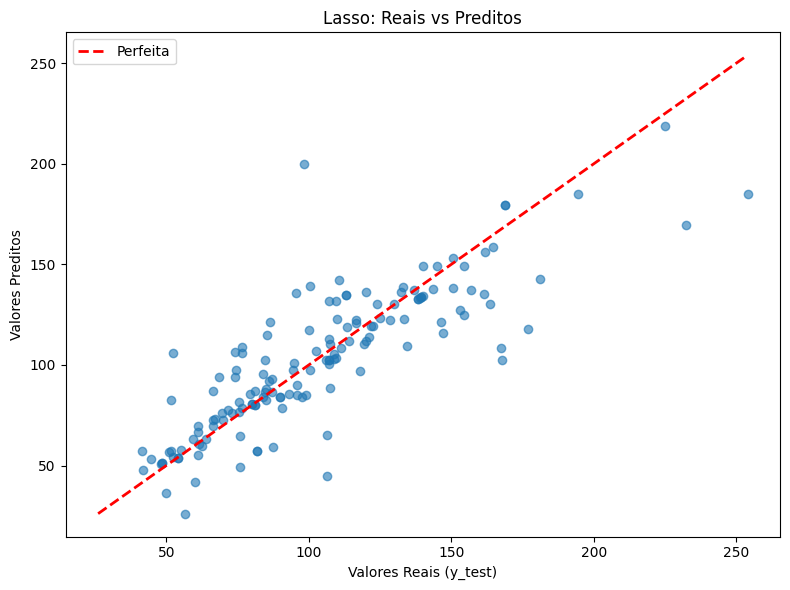

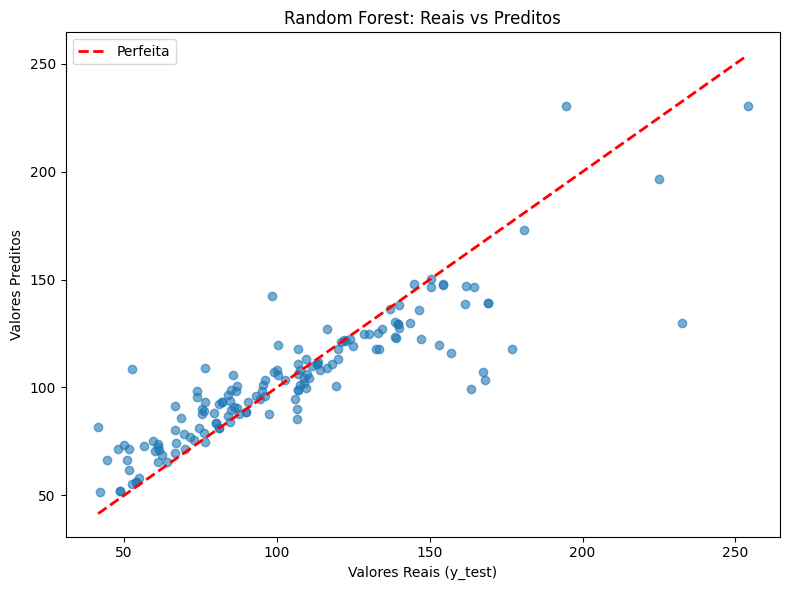

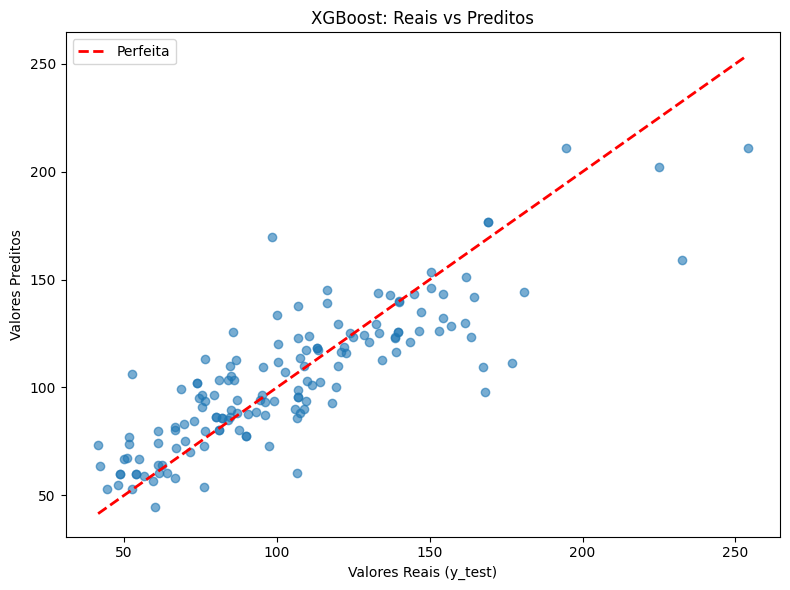

In [638]:
def plot_predicted_vs_actual(result, model_name, y_test):
    y_pred = result['y_pred']
    
    # Scatter
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.6)

    # Linha identidade
    lim_min = min(y_test.min(), y_pred.min())
    lim_max = max(y_test.max(), y_pred.max())
    plt.plot([lim_min, lim_max], [lim_min, lim_max], color='red', linestyle='--', lw=2, label='Perfeita')

    plt.xlabel("Valores Reais (y_test)")
    plt.ylabel("Valores Preditos")
    plt.title(f"{model_name}: Reais vs Preditos")
    plt.legend()
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Lasso", result_lasso),
    ("Random Forest", result_rf),
    ("XGBoost", result_xgb),
    
]:
    plot_predicted_vs_actual(result, name, y_test)

##### Modelos lineares (Lasso/Ridge)

In [639]:
def plot_coefficients(result, model_name, top_n=20, text_max_len=40):
    full_pipe = result['best_estimator']
    model = full_pipe.named_steps['model'] if isinstance(full_pipe, Pipeline) else full_pipe

    # Só modelos lineares têm coef_
    if not hasattr(model, "coef_"):
        print(f"{model_name} não tem 'coef_'; pulando.")
        return

    preprocessor = full_pipe.named_steps['pipe']
    try:
        names = preprocessor.get_feature_names_out()
    except AttributeError:
        raise ValueError("O pré-processador não suporta get_feature_names_out()")

    coefs = model.coef_
    idx = np.argsort(np.abs(coefs))[-top_n:]

    # Trunca os nomes longos
    labels = [
        (names[i] if len(names[i]) <= text_max_len 
         else names[i][:text_max_len-3] + "...")
        for i in idx
    ]

    plt.figure(figsize=(8,6))    
    plt.barh(range(top_n), coefs[idx], tick_label=labels)
    plt.xlabel("Coeficiente")
    plt.title(f"{model_name}: Top {top_n} Coefficients")
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Ridge", result_lasso),
]:
    plot_coefficients(result, name)

ValueError: O pré-processador não suporta get_feature_names_out()

#### Distribuição dos resíduos

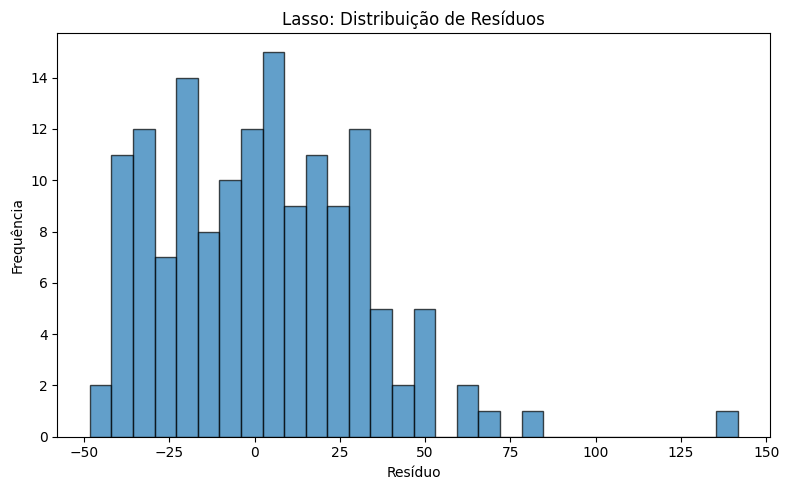

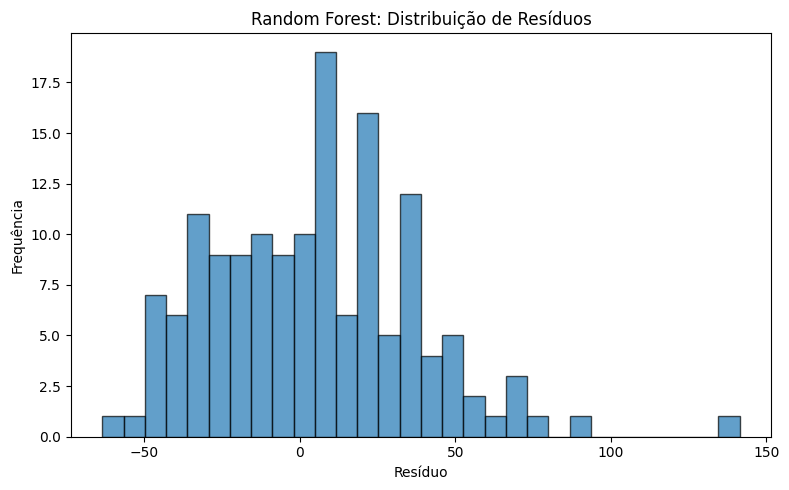

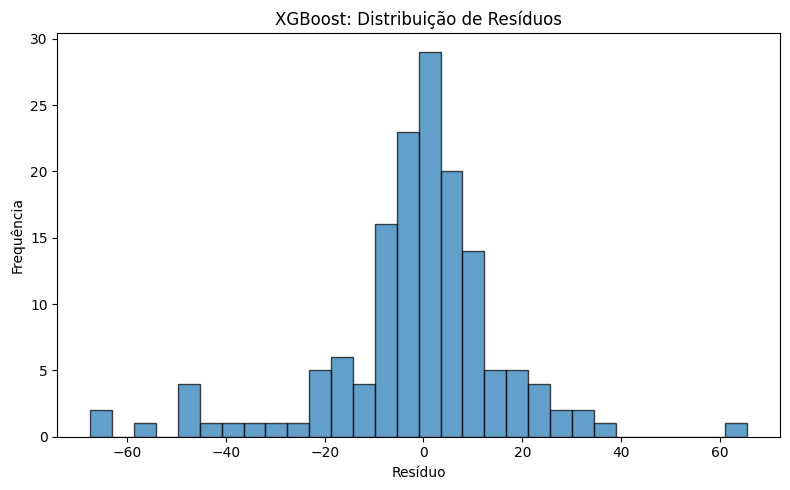

In [ ]:
def plot_residuals_hist(result, model_name, y_test):
    y_pred = result['y_pred']
    residuals = y_test - y_pred
    
    plt.figure(figsize=(8,5))
    plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel("Resíduo")
    plt.ylabel("Frequência")
    plt.title(f"{model_name}: Distribuição de Resíduos")
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Lasso", result_lasso),
    ("Random Forest", result_rf),
    ("XGBoost", result_xgb)
]:
    plot_residuals_hist(result, name, y_test)

#### Curva de Aprendizado

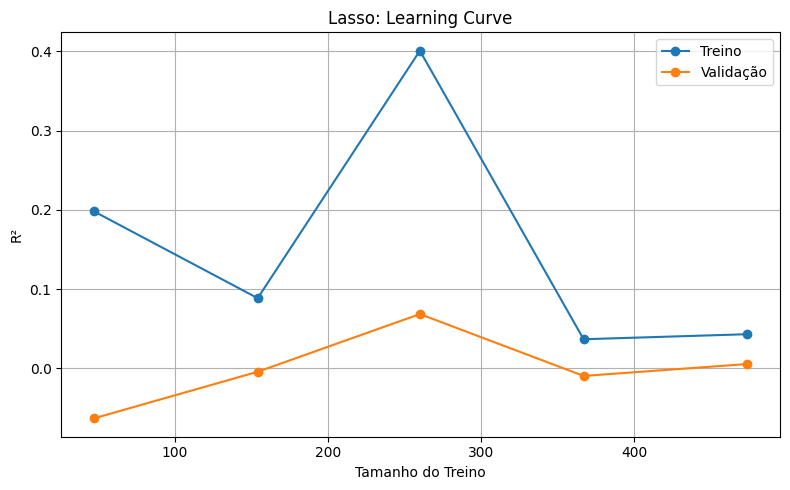

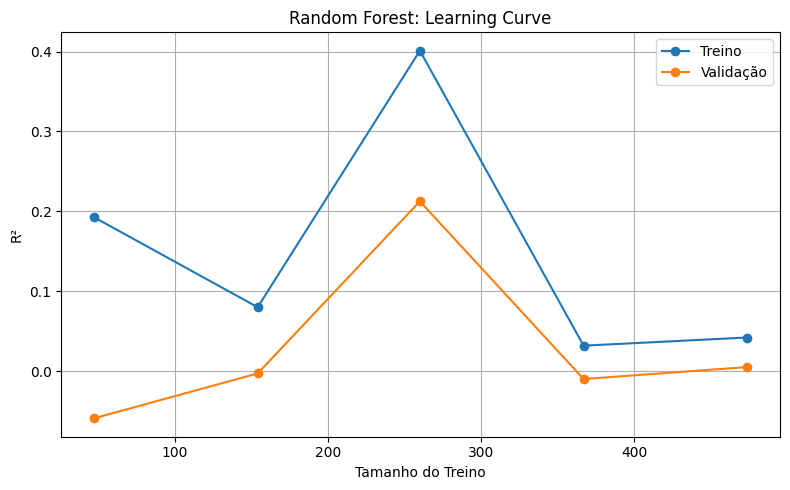

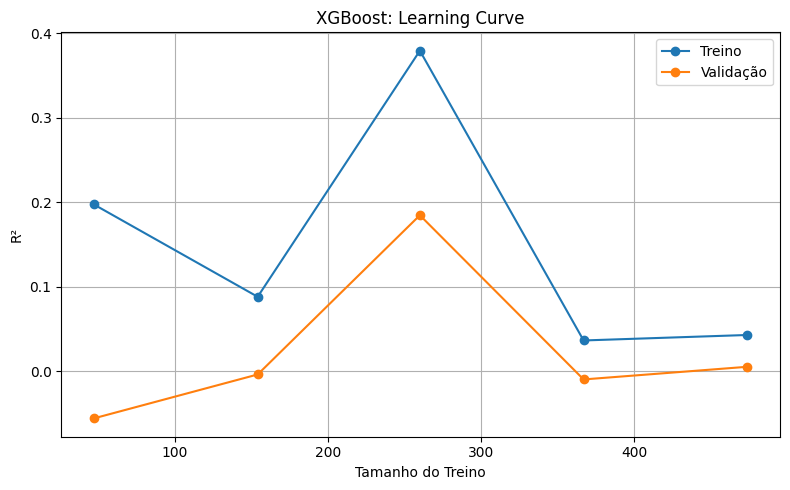

In [641]:
def plot_learning_curve(result, model_name, X_train, y_train, cv=5):
    model = result['best_estimator']

    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=cv,
        train_sizes=np.linspace(.1, 1.0, 5),
        scoring='r2', n_jobs=-1
    )
    train_mean = np.mean(train_scores, axis=1)
    val_mean   = np.mean(val_scores,   axis=1)

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_mean, 'o-', label='Treino')
    plt.plot(train_sizes, val_mean,   'o-', label='Validação')
    plt.xlabel("Tamanho do Treino")
    plt.ylabel("R²")
    plt.title(f"{model_name}: Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

for name, result in [
    ("Lasso", result_lasso),
    ("Random Forest", result_rf),
    ("XGBoost", result_xgb)
]:
    plot_learning_curve(result, name, X_train, y_train)

